In [171]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns
from Bio import SeqIO
from collections import defaultdict

In [172]:
######################################################################   INPUT   ######################################################################
original_fasta_path = "/Users/meghanmyles/Desktop/Populus_trichocarpa/genomes/v2/Ptrichocarpa_156.fa"  # string; path to fasta on which snps were called
bwa_remaps_directory = '/Users/meghanmyles/Desktop/Populus_trichocarpa/bwa_remapped_csvs'   # string; path to directory with bwa remaps
chain_remaps_directory = "/Users/meghanmyles/Desktop/Populus_trichocarpa/minimap_remapped_tsvs"     # string; path to directory with chain remaps
species_name = "Populus_trichocarpa"    # species name; string {Genus}_{species}
#######################################################################################################################################################

#######################################################################   OUTPUT   ####################################################################
# 1. An svg of whole-genome remapping stats
##### the image is named in the convention of {genus}_{species}_WholeGenome_snpRemappingStats.svg
# 2. A directory containing a set of svgs of per-genome stats, ordered by SNP count per scaffold in descending order
##### the directory is named in the convention of {genus}_{species}_{per}_{assemblage}_snpRemappingStats in the directory where the script is run
##### the images are named in the convention of {genus}_{species}_{AssemblageName}_snpRemappingStats.svg
#######################################################################################################################################################

In [173]:
warnings.filterwarnings('ignore')

# Read the FASTA file and create a dictionary with scaffold lengths
scaffold_lengths = {}
for record in SeqIO.parse(original_fasta_path, "fasta"):
    scaffold_lengths[record.id] = len(record.seq)

# Read the bwa remaps into a dictionary
bwa_remaps = {}

genome_versions = []    # also get a fun list of genome versions to use later while we're at it

for filename in os.listdir(bwa_remaps_directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(bwa_remaps_directory, filename)
        with open(filepath, 'r') as file:
            # Read CSV and assign to the dictionary
            bwa_remaps[filename] = pd.read_csv(file)

            # get genome version names
            genome_versions.append(filename.split(".")[3])

            # Add a 'source' column based on the filename
            bwa_remaps[filename]['source'] = filename.split(".")[3] + "_bwa"

            # Add 'remapped' col, telling whether or not snp remapped
            bwa_remaps[filename]['remapped'] = bwa_remaps[filename].apply(
                lambda row: 0 if pd.isna(row['new_genome_chromosome']) else 1, axis=1
            )

# Concat all dfs in the bwa_remaps dictionary
combined_bwa = pd.concat(bwa_remaps.values(), ignore_index=True)

# Calculate the number of SNPs for each old_genome_chromosome and sort in decreasing order
snp_counts = combined_bwa['old_genome_chromosome'].value_counts().reset_index()
snp_counts.columns = ['old_genome_chromosome', 'num_snps']
snp_counts = snp_counts.sort_values('num_snps', ascending=False)

# Create a list of chromosomes in numeric order
chromosome_order = snp_counts['old_genome_chromosome'].tolist()

# Merge SNP counts back into the combined_bwa df
combined_bwa = combined_bwa.merge(snp_counts, on='old_genome_chromosome')

In [174]:
# Read the chain remaps into a dictionary
chain_remaps = {}
for filename in os.listdir(chain_remaps_directory):
    # Ensure to only process valid files (e.g., .tsv or .txt)
    if filename.endswith('.tsv'):
        filepath = os.path.join(chain_remaps_directory, filename)
        with open(filepath, 'r', encoding='ISO-8859-1') as file:
            # Read and assign to the dictionary
            chain_remaps[filename] = pd.read_csv(file, delimiter="\t")

            chain_remaps[filename].columns = ['SNP_name','new_genome_chromosome', 'new_genome_base_position','old_genome_chromosome', 'old_genome_base_position']

            # Add a 'source' column based on the filename
            chain_remaps[filename]['source'] = filename

            # Add 'remapped' col, telling whether or not snp remapped
            chain_remaps[filename]['remapped'] = chain_remaps[filename].apply(
                lambda row: 0 if pd.isna(row['new_genome_chromosome']) else 1, axis=1
            )

# function to integrate chain files with combined_bwa df
def integrate_chain_data(combined_bwa, chain_data, source_name):
    # Ensure the necessary columns are correctly mapped and formatted
    chain_data['source'] = source_name  # Tag data upon combination into df
    chain_data['num_snps'] = len(chain_data)  # Count SNPs
    
    # Convert position columns to `object` type to allow None
    chain_data['old_genome_base_position'] = chain_data['old_genome_base_position'].where(
        pd.notnull(chain_data['old_genome_base_position']), None
    )
    chain_data['new_genome_base_position'] = chain_data['new_genome_base_position'].where(
        pd.notnull(chain_data['new_genome_base_position']), None
    )
    
    # Combine the dfs
    combined_result = pd.concat([combined_bwa, chain_data], ignore_index=True)
    
    return combined_result

# integrate chain files into combined_bwa df
iter = 0
for filename in chain_remaps:
    if iter == 0:
        combined_remaps = integrate_chain_data(combined_bwa, chain_remaps[filename], filename)
    else:
        combined_remaps = integrate_chain_data(combined_remaps, chain_remaps[filename], filename)
    iter += 1

In [175]:
# colors for arrows - green good, yellow ok, red bad
def get_rdylgn_color(percentage):
    cmap = plt.cm.RdYlGn
    norm = mcolors.Normalize(vmin=0, vmax=1)
    return cmap(norm(percentage))

# put one arrow + its numeric label on the plot
def add_arrow_and_text(ax, start_pos, end_pos, y_level, percentage):
    color = get_rdylgn_color(percentage)
    rad = 0.2  # Control point for curvature
    arrow_length = end_pos - start_pos  # Calculate horizontal distance

    # Calculate the height of the arrow based on the arc
    arrow_radius = arrow_length / (2 * np.sin(rad / 2))

    arrow_height = rad * arrow_length  # Height of the arc based on rad and horizontal distance

    # Create the arrow
    arrow = patches.FancyArrowPatch(
        (start_pos, y_level),
        (end_pos, y_level),
        connectionstyle=f"arc3,rad={rad}",
        color=color,
        arrowstyle='->',
        lw=5,
        shrinkA=0,
        shrinkB=0,
        mutation_scale=20,
        zorder=3  # Ensure arrow is on top
    )
    ax.add_patch(arrow)
    
    # Calculate the midpoint for the text box
    box_x = (start_pos + end_pos) / 2
    box_y = y_level - arrow_height  # Centered vertically in the arrow arc
    box_width = 0.03
    box_height = 0.01

    # Create the text box
    text_box = patches.FancyBboxPatch(
        (box_x, box_y),
        width=box_width,
        height=box_height,
        boxstyle="round,pad=0.12",
        facecolor='#333333',
        edgecolor=color,
        linewidth=2,
        zorder=4  # Ensure text box is above arrow
    )
    ax.add_patch(text_box)

    # Add text inside the text box
    ax.text(
        box_x + box_width / 2,
        box_y + box_height / 2,
        f"{percentage:.1%}",
        color='white',
        ha='center',
        va='center',
        fontsize=9.5,
        zorder=5  # Ensure text is on top
    )

# calculate proportion of snps remapped (to be put on arrows)
def calculate_proportion(data, source_version):
    source_version_str = str(source_version)
    subset = data[data['source'] == source_version_str]
    # Explicitly count rows where 'remapped' is 1
    yes_count = (subset['remapped'] == 1).sum()
    total_count = len(subset)
    return yes_count / total_count if total_count > 0 else 0

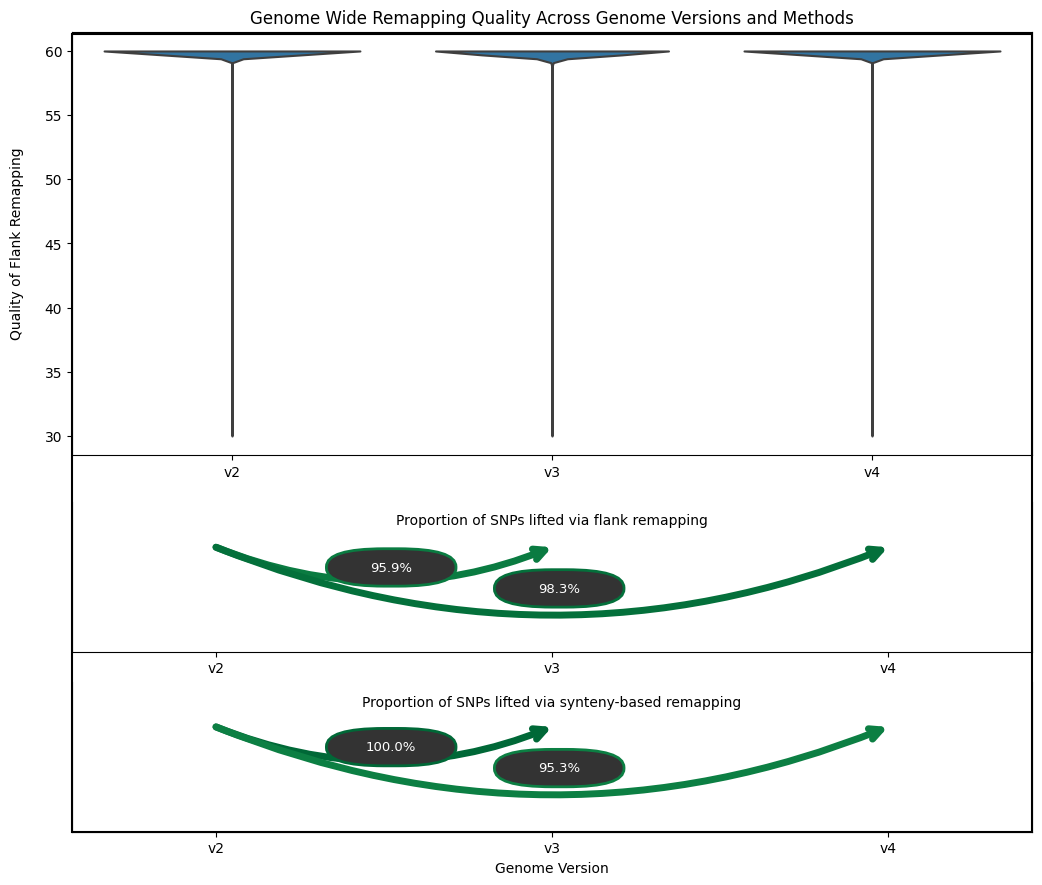

In [176]:
# Determine how many figures to make
num_cols = len(genome_versions)

# calculate proportions for arrows
proportions = {}
for source in combined_remaps['source'].unique():
    proportions[source] = calculate_proportion(combined_remaps, source)

# Sort bwa proportions
bwa_props = [(source, prop) for source, prop in proportions.items() if 'bwa' in source.lower()]
bwa_props.sort()  # Sort numerically by source name

# get unique bwa remap names
unique_keys = [key for key, _ in bwa_props]

# Create the main figure with as many columns as there were unique remaps
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(3, 1, height_ratios=[3, 1, 1])

# Create left column gridspec for violin and arrows with added vertical space
# Use a separate subgridspec for arrows and violin for finer control over spacing
gs_violin = gs[0, 0].subgridspec(1, 1, hspace=0)  # No additional space needed here
gs_arrows = gs[1:, 0].subgridspec(2, 1, height_ratios=[1, 1], hspace=0.2)  # Adds space between BWA and chain arrow facets

# Set up axes based on these subgridspecs
ax_violin = fig.add_subplot(gs_violin[0])
ax_bwa = fig.add_subplot(gs_arrows[0, 0])
ax_chain = fig.add_subplot(gs_arrows[1, 0])

sns.violinplot(
    x='source', 
    y='remapping_quality', 
    data=combined_remaps, 
    order=[key for key in unique_keys], 
    inner=None,
    linewidth=1.5,
    cut=0,
    ax=ax_violin
)

# Calculate evenly spaced x positions
unique_versions = [key.split('_')[0] for key in unique_keys]
num_versions = len(unique_versions)

violin_facet_width =  0.6 + 0.7 * (num_cols - 1)
margin = 0.3    # Left margin for first position
remaining_width = violin_facet_width - (2 * margin)  # Space for arrows excluding margins
x_positions_chain = [margin + (i * remaining_width / (num_versions - 1)) for i in range(num_versions)]

ax_violin.set_xlabel('')
ax_violin.set_ylabel("Quality of Flank Remapping", labelpad=15)
ax_violin.yaxis.set_label_coords(-0.05, 0.5)
ax_violin.set_title("Genome Wide Remapping Quality Across Genome Versions and Methods")
ax_violin.set_xticklabels(unique_versions)

# Middle subplot for BWA remapping arrows
ax_bwa.set_ylim(0, 1)
ax_bwa.axis('on')
ax_bwa.set_xlabel('')
ax_bwa.set_ylabel('')
ax_bwa.set_yticks([])  

# Bottom subplot for chain remapping arrows
# Add arrows for bwa, starting from second proportion
for i in range(1, len(bwa_props)):
    # Arrow goes from position i-1 to position i
    # representing the proportion at position i
    add_arrow_and_text(ax_bwa, 0.3, 1 + (i - 1) * 0.7, 0.7, bwa_props[i][1])

# Handle chain plots
chain_props = [(source, prop) for source, prop in proportions.items() if 'minimap' in source.lower()]
chain_props.sort()
for i in range(0, len(chain_props)):
    add_arrow_and_text(ax_chain, 0.3, 1 + 0.7 * i, 0.7, chain_props[i][1])

ax_chain.set_xlabel("Genome Version")

# Set the x-ticks with the calculated positions
for ax in [ax_bwa, ax_chain]:
    ax.set_xlim(0, violin_facet_width)
    ax.set_xticks(x_positions_chain)
    ax.set_xticklabels(unique_versions)

    ax.set_ylim(0, 1)
    ax.set_ylabel('')
    ax.set_yticks([])

    # Hide the top x-axis
    ax.xaxis.set_tick_params(top=False)  # Disable ticks on top x-axis
    ax.spines['top'].set_visible(False)   # Hide the top spine    

# Position titles halfway between plot top and arrow top
bwa_title_y = (ax_bwa.get_position().y1 + ax_bwa.get_position().y0) * 0.58
chain_title_y = (ax_chain.get_position().y1 + ax_chain.get_position().y0) * 0.63

# Add centered titles
fig.text(0.5, bwa_title_y, 'Proportion of SNPs lifted via flank remapping', 
        va='center', ha='center', fontsize=10)
fig.text(0.5, chain_title_y, 'Proportion of SNPs lifted via synteny-based remapping', 
        va='center', ha='center', fontsize=10)

# Adjust layout manually
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Get the combined position of all facets and the space in between them
violin_pos = ax_violin.get_position()
bwa_pos = ax_bwa.get_position()
chain_pos = ax_chain.get_position()

# Calculate the combined width and height including the hspace
combined_x = violin_pos.x0
combined_width = violin_pos.width
combined_y = chain_pos.y0
combined_height = violin_pos.height + bwa_pos.height + chain_pos.height + 0.075  # Adjust for hspace


# Add a rectangle patch with a solid line
box = patches.Rectangle(
    (combined_x, combined_y),
    combined_width,
    combined_height,
    linewidth=1.5,
    edgecolor='black',
    facecolor='none',
    linestyle='-'
)
fig.add_artist(box)


# save as svg
file_name = f"{species_name}_{unique_versions[0]}_snpRemappingStats.svg"
plt.savefig(os.path.join(os.getcwd(), file_name), format = 'svg')

In [177]:
# Function to subset the df by chromosomes and store in a dictionary
def get_subsets_by_chromosome(df, chromosomes):
    subsets = {}
    for chrom in chromosomes:
        subsets[chrom] = df[df['old_genome_chromosome'] == chrom].copy()  # Non-destructive copying
    return subsets

def natural_sort_key(s):
    """
    Return a key for natural sorting that handles both strings and numbers.
    Converts string representation of scaffold to a tuple of strings and integers.
    """
    
    # Convert float or int to string if necessary
    s = str(s)
    
    # Split string into list of strings and numbers
    def convert(text):
        return int(text) if text.isdigit() else text.lower()
    return [convert(c) for c in re.split('([0-9]+)', s)]

def get_fixed_color_mappings(subsets_by_chromosome, unique_keys):
    """
    Create color mappings for all chromosomes/scaffolds, including those that appear in the pie charts.
    Returns two color maps (left and right) ensuring all possible scaffolds have a color.
    Handles mixed types (str, float, int) in scaffold names.
    """
    # Get all unique scaffold names across all data
    all_scaffolds = set()
    for scaffold_data in subsets_by_chromosome.values():
        for source in unique_keys:
            subset = scaffold_data[scaffold_data['source'] == source]
            # Convert to strings when adding to set
            all_scaffolds.update(str(x) for x in subset['new_genome_chromosome'].unique())
            all_scaffolds.update(str(x) for x in subset['old_genome_chromosome'].unique())
            
            # Also check remapped locations
            remapped_subset = subset[subset['remapped'] == 1]
            all_scaffolds.update(str(x) for x in remapped_subset['new_genome_chromosome'].unique())
    
    # Convert to sorted list using natural sort
    all_scaffolds = sorted(list(all_scaffolds), key=natural_sort_key)
    n_colors = len(all_scaffolds)
    
    # Generate color lists with enough colors
    left_color_list = list(plt.cm.Set1(np.linspace(0, 1, max(n_colors, 9))))
    right_color_list = list(plt.cm.Set2(np.linspace(0, 1, max(n_colors, 8))))
    
    # If we need more colors, extend the lists
    while len(left_color_list) < n_colors:
        left_color_list.extend(list(plt.cm.Set1(np.linspace(0, 1, 9))))
    while len(right_color_list) < n_colors:
        right_color_list.extend(list(plt.cm.Set2(np.linspace(0, 1, 8))))
    
    # Trim to exact size needed
    left_color_list = left_color_list[:n_colors]
    right_color_list = right_color_list[:n_colors]
    
    # Create color maps with default color for missing scaffolds
    default_color = (0.7, 0.7, 0.7, 1.0)  # Gray color for any missing scaffolds
    left_colors = defaultdict(lambda: default_color)
    right_colors = defaultdict(lambda: default_color)
    
    # Fill the color maps, ensuring keys are strings
    for scaffold, color in zip(all_scaffolds, left_color_list):
        left_colors[str(scaffold)] = color
    for scaffold, color in zip(all_scaffolds, right_color_list):
        right_colors[str(scaffold)] = color
    
    return left_colors, right_colors

def create_pie_chart_with_jittered_labels(ax, data, title, color_map):
    # Convert index to strings for color mapping
    data.index = data.index.astype(str)
    
    # Get colors for each wedge
    default_color = (0.7, 0.7, 0.7, 1.0)
    color_list = [color_map.get(str(chromosome), default_color) for chromosome in data.index]

    radius = 1.2  # Adjusted pie chart radius
    line_length_factor = 1.5  # This controls line lengths independently
    
    wedges, _ = ax.pie(
        data.values, 
        labels=[''] * len(data),
        colors=color_list,
        startangle=90,
        radius=radius,
        center=(0, -0.4)
    )
    
    total = sum(data)
    angles = []
    start_angle = 90
    current_angle = start_angle
    
    # Adjust angles for clockwise direction
    for value in data:
        angle = (value / total) * 360
        center_angle = current_angle + angle / 2
        angles.append(np.deg2rad(center_angle))
        current_angle += angle
    
    label_gap = 0.35
    label_data = list(zip(angles, data.index, data.values))
    label_data.sort(key=lambda x: -np.sin(x[0]))
    
    used_positions = []
    
    for i, (angle, label, value) in enumerate(label_data):
        # Label positions using line length factor, independent of the pie radius
        x = line_length_factor * np.cos(angle)
        y = line_length_factor * np.sin(angle) - 0.4  # Adjust y-coordinate for center offset
        
        # Avoid overlap in y-coordinates
        while any(abs(y - used_y) < label_gap for _, used_y in used_positions):
            y -= label_gap
            x = np.sign(x) * np.sqrt(line_length_factor**2 - (y + 0.4)**2)  # Adjust calculation for offset
        
        used_positions.append((x, y))
        
        percentage = f'{(value / total) * 100:.1f}%'
        label_text = f'{label}\n({percentage})'
        
        ha = 'left' if x >= 0 else 'right'

        pie_x = radius * np.cos(angle)
        pie_y = radius * np.sin(angle) - 0.4  # Adjust for center offset
        
        bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.9)
        connection_style = "arc3,rad=0.15" if x >= 0 else "arc3,rad=-0.15"
        arrow_props = dict(arrowstyle="-", connectionstyle=connection_style, color='gray', alpha=0.6)
        
        label_x = x
        label_y = y
        
        ax.annotate(
            label_text,
            xy=(pie_x, pie_y),
            xytext=(label_x, label_y),
            horizontalalignment=ha,
            verticalalignment='center',
            bbox=bbox_props,
            arrowprops=arrow_props,
            fontsize=9
        )
    
    ax.set_aspect('equal')
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-2.0, 1.6) 
    
    # Adjust title position
    ax.text(0, -0.4, title,
        horizontalalignment='center',
        verticalalignment='center',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'),
        transform=ax.transData
    )
    
    return wedges

def format_title(col_name, snp_count_dictionary, ax):
    snp_count = snp_count_dictionary.get(col_name, 0)
    scaffold_length = scaffold_lengths.get(col_name, 0)
    
    # Escape underscores for LaTeX
    col_name_escaped = col_name.replace("_", r"\_")
    
    # Create separate lines and join with \n
    lines = [
        f"$\\mathbf{{Remapping\\ Quality\\ of\\ SNPs}}$",
        f"$\\mathbf{{on\\ {col_name_escaped}}}$",
        f"$\\mathbf{{Across\\ Versions\\ and\\ Tools}}$",
        f"$\\mathbf{{SNP\\ Count:}}$ {snp_count:,}",
        f"$\\mathbf{{Length:}}$ {scaffold_length:,} bp"
    ]
    title = '\n'.join(lines)
    
    # Set title with adjusted position
    ax.set_title(title, pad=10, y=1.05)

def calculate_proportion_scaffold(data, source_version, scaffold_name):
    source_version_str = str(source_version)
    # Filter for both source version and scaffold name
    subset = data[
        (data['source'] == source_version_str) & 
        (data['old_genome_chromosome'] == scaffold_name)
    ]
    
    # Calculate proportion of remapped entries
    yes_count = (subset['remapped'] == 1).sum()
    total_count = len(subset)
    return yes_count / total_count if total_count > 0 else 0

In [178]:
# Get the version number from the first BWA remap
first_bwa_version = unique_keys[0].split('_')[0].replace('v', '')

# Set a fixed width for the violin facet
violin_facet_width = 6  # Set a fixed width regardless of number of unique keys

# Create the directory name
directory_name = f"{species_name}_v{first_bwa_version}_snpRemappingStats"
os.makedirs(directory_name, exist_ok=True)

# Get unique chromosomes where source == first bwa remap in list
chromosomes_to_subset = combined_remaps[combined_remaps['source'] == unique_keys[0]]['old_genome_chromosome'].unique()

# Get the dictionary of subset dfs based on the chromosomes from the first bwa remap
subsets_by_chromosome = get_subsets_by_chromosome(combined_remaps, chromosomes_to_subset)

# Get SNP counts and color mappings (rest of the setup code remains the same)
snp_count_dict = dict(zip(snp_counts['old_genome_chromosome'], snp_counts['num_snps']))
left_color_map, right_color_map = get_fixed_color_mappings(subsets_by_chromosome, unique_keys)
snp_counts = {scaffold_name: len(scaffold_data) for scaffold_name, scaffold_data in subsets_by_chromosome.items()}
sorted_scaffold_names = sorted(snp_counts, key=snp_counts.get, reverse=True)

# Iterate over each unique scaffold_name in sorted order
for scaffold_name in sorted_scaffold_names:
    scaffold_data = subsets_by_chromosome[scaffold_name]
    
    # Get and sort sources
    all_sources = scaffold_data['source'].unique()
    bwa_sources = sorted([src for src in all_sources if 'bwa' in src.lower()])
    chain_sources = sorted([src for src in all_sources if 'minimap' in src.lower()])

    # Calculate the number of pie charts needed for both rows
    num_bwa_pies = max(0, len(bwa_sources) - 1)
    num_chain_pies = len(chain_sources)
    total_pie_columns = max(num_bwa_pies, num_chain_pies)

    # Calculate figure width based on fixed violin width and number of pie charts
    pie_width_per_col = 4
    total_width = violin_facet_width + (pie_width_per_col * total_pie_columns)
    
    # Create the figure and gridspec
    fig = plt.figure(figsize=(total_width, 9))
    gs = fig.add_gridspec(
        2,
        2,
        height_ratios=[1, 1],
        width_ratios=[violin_facet_width, pie_width_per_col * total_pie_columns],
        wspace=0,
        hspace=0.2
    )

    # Create left column gridspec for violin and arrows
    gs_left = gs[:, 0].subgridspec(
        3, 
        1, 
        height_ratios=[3, 1, 1], 
        hspace=0.15
    )

    # Create violin plot with fixed width
    ax_violin = fig.add_subplot(gs_left[0])
    
    # Create violin plot with fixed width using seaborn's native parameters
    sns.violinplot(
        x='source', 
        y='remapping_quality', 
        data=scaffold_data, 
        order=[key for key in unique_keys], 
        inner=None,
        linewidth=1.5,
        cut=0,
        ax=ax_violin,
        width=0.8  # Control violin width directly
    )

    # Adjust the violin plot axes
    ax_violin.set_xlim(-0.5, len(unique_keys) - 0.5)  # Set proper x-axis limits
    
    # Create arrow facets with fixed width
    ax_bwa = fig.add_subplot(gs_left[1])
    ax_chain = fig.add_subplot(gs_left[2])

    # Remove the top x-axis from the arrow facets
    ax_bwa.spines['top'].set_visible(False)
    ax_chain.spines['top'].set_visible(False)

    # Calculate proportions
    proportions = {}
    for source in scaffold_data['source'].unique():
        proportions[source] = calculate_proportion_scaffold(combined_remaps, source, scaffold_name)

    # Earlier code remains the same until the arrow plotting section

    # Set up consistent x positions based on violin plot spacing
    x_positions = np.arange(len(unique_versions))  # [0, 1] for two versions
    
    # Plot chain arrows with correct x positions
    for i in range(len(chain_sources)):
        start_x = x_positions[0]  # Start at first version position
        end_x = x_positions[1]    # End at second version position
        add_arrow_and_text(ax_chain, start_x, 1 + 0.8 * i, 0.6, proportions[chain_sources[i]])

    # Plot BWA arrows with correct x positions
    for i in range(1, len(bwa_sources)):
        start_x = x_positions[0]  # Start at first version position
        end_x = x_positions[1]    # End at second version position
        add_arrow_and_text(ax_bwa, start_x, 1 + (i - 1) * 0.8, 0.6, proportions[bwa_sources[i]])

    # Set up axes formatting
    unique_versions = sorted(set(src.split('_')[0] for src in bwa_sources))
    ax_violin.set_ylabel("Quality of Flank Remapping")
    ax_violin.set_ylim(28, 62)
    ax_violin.set_xticklabels(unique_versions)

    format_title(scaffold_name, snp_count_dict, ax_violin)

    # Set up axes labels and ticks for arrow facets
    ax_chain.set_xlabel("Genome Version")
    
    # Set consistent limits and formatting for arrow facets
    for ax in [ax_bwa, ax_chain]:
        ax.set_xlim(-0.5, len(unique_versions) - 0.5)  # Match violin plot x limits
        ax.set_ylim(0, 1)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(unique_versions)
        ax.xaxis.set_label_position('bottom')
        ax.xaxis.set_visible(True)
        ax.set_ylabel('')
        ax.set_yticks([])

    # Create right column gridspec for pie charts
    gs_right = gs[:, 1].subgridspec(
        2,
        total_pie_columns,
        height_ratios=[1, 1],
        hspace=0
    )

    # Create BWA pie charts (top row)
    for i, source in enumerate(bwa_sources[1:]):  # Skip first BWA source
        ax_pie = fig.add_subplot(gs_right[0, i])
        subset = scaffold_data[scaffold_data['source'] == source]
        counts = subset['new_genome_chromosome'].value_counts()
        
        from_version = first_bwa_version
        to_version = source.split('_')[0].replace('v', '')
        title = f'v{from_version} to v{to_version}\nflank remapping'
        
        color_map = right_color_map if i % 2 else left_color_map
        create_pie_chart_with_jittered_labels(ax_pie, counts, title, color_map)
        ax_pie.set_position([
            gs_right[0, i].get_position(fig).x0,  # Keep x position
            gs_right[0, i].get_position(fig).y0,  # Keep y position
            gs_right[0, i].get_position(fig).width,  # Keep width
            gs_right[0, i].get_position(fig).height  # Keep height
        ])
        ax_pie.set_xticks([])
        ax_pie.set_yticks([])

    # Create chain pie charts (bottom row)
    for i, source in enumerate(chain_sources):
        ax_pie = fig.add_subplot(gs_right[1, i])
        subset = scaffold_data[scaffold_data['source'] == source]
        counts = subset['new_genome_chromosome'].value_counts()
        
        from_version = first_bwa_version
        to_version = bwa_sources[i + 1].split('_')[0].replace('v', '')
        title = f'v{from_version} to v{to_version}\nsynteny-based\nremapping'
    
        color_map = right_color_map if i % 2 else left_color_map
        create_pie_chart_with_jittered_labels(ax_pie, counts, title, color_map)
        ax_pie.set_position([
            gs_right[1, i].get_position(fig).x0,  # Keep x position
            gs_right[1, i].get_position(fig).y0,  # Keep y position
            gs_right[1, i].get_position(fig).width,  # Keep width
            gs_right[1, i].get_position(fig).height  # Keep height
        ])
        ax_pie.set_xticks([])
        ax_pie.set_yticks([])

    # Add titles
    pie_center_x = (gs_right[0, 0].get_position(fig).x0 + gs_right[0, -1].get_position(fig).x1) / 2
    fig.text(pie_center_x, 0.95, 
             r"$\mathbf{Remapped\ SNP\ Locations\ by}$" + '\n' + 
             r"$\mathbf{Genome\ Assembly\ Unit}$", 
             va='top', ha='center', fontsize=12)

    arrow_title_x = ax_violin.get_position().x0 + (ax_violin.get_position().width / 2)
    fig.text(arrow_title_x, bwa_title_y,
             'Proportion of SNPs lifted via flank remapping',
             va='center', ha='center', fontsize=10)
    fig.text(arrow_title_x, chain_title_y,
             'Proportion of SNPs lifted via synteny-based remapping',
             va='center', ha='center', fontsize=10)
    
    # Get the combined position of all facets and the space in between them
    violin_pos = ax_violin.get_position()
    bwa_pos = ax_bwa.get_position()
    chain_pos = ax_chain.get_position()
    
    # Calculate the combined width and height including the hspace
    combined_x = violin_pos.x0
    combined_width = violin_pos.width
    combined_y = chain_pos.y0
    combined_height = violin_pos.height + bwa_pos.height + chain_pos.height + 0.071  # Adjust for hspace

    # Add a rectangle patch with a solid line
    box = patches.Rectangle(
        (combined_x, combined_y),
        combined_width,
        combined_height,
        linewidth=1.5,
        edgecolor='black',
        facecolor='none',
        linestyle='-'
    )
    fig.add_artist(box)

    # Get position details for gs_right by accessing the first and last pie chart positions
    top_pie_pos = gs_right[0, 0].get_position(fig)
    bottom_pie_pos = gs_right[1, -1].get_position(fig)

    # Calculate combined width and height for gs_right
    right_combined_x = top_pie_pos.x0
    right_combined_width = top_pie_pos.width * total_pie_columns + 0.04
    right_combined_y = bottom_pie_pos.y0
    right_combined_height = top_pie_pos.height + bottom_pie_pos.height + 0.084  # Adjust for hspace

    # Add rectangle around gs_right
    box_right = patches.Rectangle(
        (right_combined_x, right_combined_y),
        right_combined_width,
        combined_height,
        linewidth=1.5,
        edgecolor='black',
        facecolor='none',
        linestyle='-'
    )
    fig.add_artist(box_right)

    # Save the figure
    output_filename = f"{species_name}_v{first_bwa_version}_{scaffold_name}_snpRemappingStats.svg"
    plt.savefig(os.path.join(directory_name, output_filename), format='svg', bbox_inches='tight')
    plt.close(fig)